## Well ties and wavelet estimation methods

The aim of this notebook is to illustrate a number of wavelet estimation methods regularly, or not so regularly used in seismic interpretation and well ties. 

We look at four approaches of estimating a wavelet for making a synthetic 

1. Eyeballing a Ricker Wavelet from seismic's frequency content

2. Autocorrelation 

3. Spectral divison method 

4. Wiener filtering

Lastly we evaluate the quality of these wavelets in regards to their fittedness to the observed seismic data

Things to consider / do / include

* Pearson's correlation coefficient

* Showing difference plot

* RMS error of data-synthetic

In [50]:
import numpy as  np
from numpy.linalg import lstsq
from scipy import fft, ifft
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from bruges.filters import ricker

% matplotlib inline

# Get seismic data

Get data from a single crossline that I exported from OpendTect.

In [60]:
%run wavelet_utils/wavelet_utils.py

In [61]:
segy = 'data/XL_1153_Penobscot.segy'

In [62]:
data = get_seismic('data/XL_1153_Penobscot.segy')

In [63]:
dt = get_sample_rate_in_seconds(segy)
dt

0.004

# Get well data

In [64]:
# Acoustic Impedance
ip = np.nan_to_num(np.loadtxt('data/ip.txt'))
# Time base of Reflectivity series
t_r = np.loadtxt('data/tbaseRC.txt')

In [65]:
# other data (not sure if this is used? MAYBE DELETED)
log_start = 0.4105 # start time of log
x = 100 # trace position of the well along the line
ilx = 1176
s = data[:,x]

## Show the well

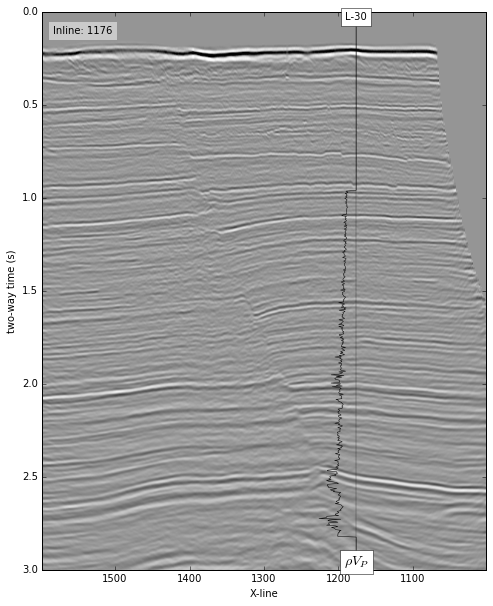

In [66]:
seismic_and_well_plot(data, log=ip, t_r=t_r)

# 1. Wavelet estimation by visual inspection

## Trace Bandwidth 

Plot on a decibel scale

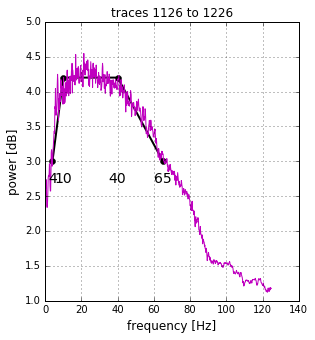

In [71]:
S, ax = get_spectrum(data, x=100, dt=dt, ilx=1176, r=50)
freqs = [4,10,40,65]
c = 1.0
p = c*np.array([3.0,4.2,4.2,3.0])
ax.plot(freqs, p, 'ko-', lw=2, zorder=0, ms=6)

#for line, val in zip(freqs[1:-1],p[1:-1]):
#    ax.axvline(line, ymin=0.5, ymax = val, linewidth=2, color='k', alpha=0.25)

for f in freqs:
    ax.text(f,0.95*p[0],f, ha='center', va='top', fontsize=14)

## Ormsby

In [72]:
from bruges.filters.wavelets import ormsby, ricker

In [73]:
from bruges.filters.wavelets import ormsby, ricker
duration = 0.256 # seconds
freq_rick=32
orms = ormsby(duration, dt=0.004, f=freqs)
ricker = ricker(duration, dt, freq_rick)

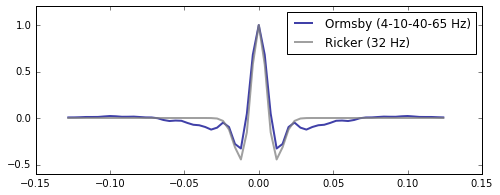

In [74]:
tw = np.arange(-len(ricker)//2,len(ricker)//2,1)*dt

fig =plt.figure(figsize=(8,3))
# plot Ormsby wavelet
plt.plot(tw, orms, 'darkblue', lw=2, alpha=0.75, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
# plot Ricker wavelet
plt.plot(tw, ricker, 'grey', lw=2, alpha=0.75, 
         label='Ricker (%i Hz)' % (freq_rick))
plt.legend(loc=1)

In [75]:
w1 = orms

## Trace 

In [76]:
t = get_tbase(segy)

(<matplotlib.axes._subplots.AxesSubplot at 0x11bbdcda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c0e8208>)

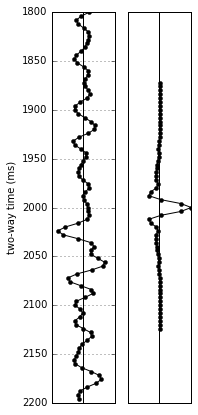

In [77]:
aa, bb = 450, 550
plot_trace_segment(data, x=100, t=t, dt=dt, w=orms, tw=2000+tw*1000, top_sample=aa, bottom_sample=bb, markersize=4)

## Phase spectra of seismic trace

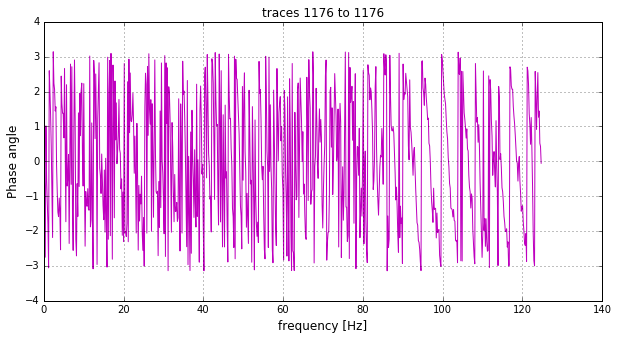

In [79]:
Phase = np.angle(fft(s)[0:len(faxis)//2])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(faxis[:len(faxis)//2], Phase,'m', lw=1)
ax.set_xlabel('frequency [Hz]', fontsize=12)
ax.set_ylabel('Phase angle', fontsize=12)
ax.grid()
ax.set_title('traces %i to %i' %(ilx, ilx)) # format code for integer string replacement


# 2 Wavelet estimation by auto correlation

Autocorrelation (time domain auto correlation)

`np.correlate(norm(s_crop), norm(s_crop), mode='same')`

In [ ]:
t_r = np.loadtxt('data/tbaseRC.txt')
r = np.loadtxt('data/RC_t.txt')

In [83]:
n1 = 250 # first time sample
dn = 450 # number of time samples
dw = 64 # length of wavelet (in time samples 0.256 s)

In [185]:
from ipywidgets import interact

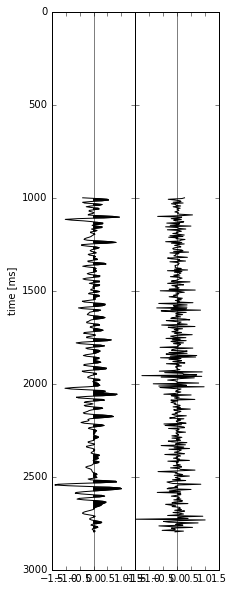

In [186]:
# plotting stuff
@interact(n1=(0, 500), dn=(300,600))
def plot_trace(n1,dn):
    trace = norm(data[n1:n1+dn, x])
    r_crop = r[n1:n1+dn]
    
    fig = plt.figure(figsize=(3.0, 10))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # plot seismic trace
    ax.plot(trace, t[n1:n1+dn], 'k')
    ax.axvline(0, color='k', alpha=0.5)
    ax.fill_betweenx(t[n1:n1+dn], trace,  0, trace > 0.0,  color='k', alpha = 1.0)
    ax.set_xlim((-1.5,1.5))
    ax.set_ylim((0,3000))
    ax.set_ylabel('time [ms]')
    ax.invert_yaxis()


    # plot reflectivity series
    ax2.plot(norm(r_crop), t[n1:n1+dn], 'k')
    ax2.axvline(0, color='k', alpha=0.5)
    ax2.set_yticklabels([])
    ax2.set_xlim((-1.5,1.5))
    ax2.set_ylim((0,3000))
    ax2.invert_yaxis()
    fig.subplots_adjust(wspace=0, hspace=0)

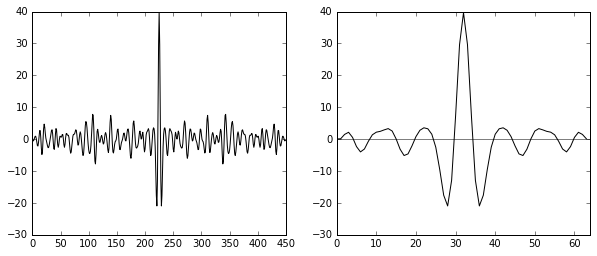

In [187]:
@interact(n1=(0, 500), dn=(300,600))
def plot_trace(n1,dn):
    trace = norm(data[n1:n1+dn, x])
    r_crop = r[n1:n1+dn]

    acorr = np.correlate(norm(trace), norm(trace), mode='same')
    w2 = acorr[len(trace)//2-dw//2:len(trace)//2+dw//2]

    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
    ax.plot(acorr,'k')
    ax2 = fig.add_subplot(122)
    ax2.plot(w2,'k')
    ax2.set_xlim(0,64)
    ax2.axhline(0,color='k',alpha=0.5)

Note autocorrelation can also be done as

`fft(s_crop)*fft(s_crop).conjugate()`


In [192]:
W2 = fft(w2)
fax =  get_faxis(w2,dt)

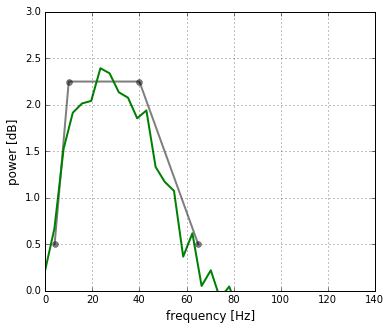

In [194]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
Y = np.log10(abs(W2[:len(fax)//2]))
#Y2 = np.log10(abs(W2_crop[:len(fax)//2]))
ax.plot(fax[:len(fax)//2], Y,'g', lw=2)
#ax.plot(fax[:len(fax)//2], Y2,'b', lw=2)
ax.set_xlabel('frequency [Hz]', fontsize=12)
ax.set_ylabel('power [dB]', fontsize=12)
ax.set_ylim(0,3)
ax.grid()
ax.plot(freqs, [0.5, 2.25, 2.25, 0.5], 'ko-', lw=2, zorder=0, ms=6, alpha=0.5)
#ax.set_title('traces %i to %i' %(ilx-r, ilx+r)) # format code for integer string replacement

# 3. Wavelet estimation by spectral division

In [195]:
# Reflectivity series
r = np.nan_to_num(np.loadtxt('data/RC_t.txt'))

In [196]:
S = fft(norm(s_crop))
R = fft(norm(r_crop))

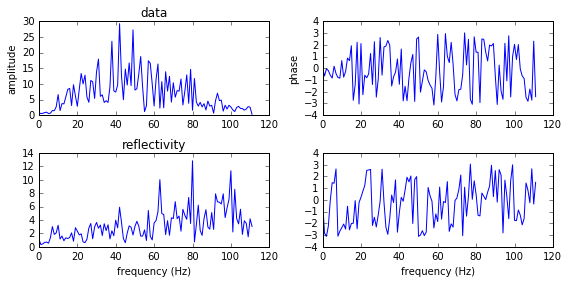

In [198]:
f = plt.figure(figsize=(8,4))

a, b = 0, len(S)//4

ax11 = f.add_subplot(221)
ax11.plot(abs(S[a:b]))
ax11.set_ylabel('amplitude')
ax11.set_title('data')

ax12 = f.add_subplot(223)
ax12.plot(abs(R[a:b]))
ax12.set_xlabel('frequency (Hz)')

ax21 = f.add_subplot(222)
ax21.plot(np.angle(S[a:b]))
ax21.set_ylabel('phase')
ax12.set_title('reflectivity')
ax22 = f.add_subplot(224)
ax22.plot(np.angle(R[a:b]))
ax22.set_xlabel('frequency (Hz)')
f.tight_layout()

We can't divide things by zero, so for band-limited stuff, Fourier components are zero
in the case of well logs we can divide by the reflectivity in the Fourier domain

In [199]:
W3 = S / R

In [200]:
def smooth(x,window_len=60,window='hanning'):
  
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    
    y=np.convolve(w/w.sum(),s, mode='same')
    return y[window_len-1:-(window_len-1)] 

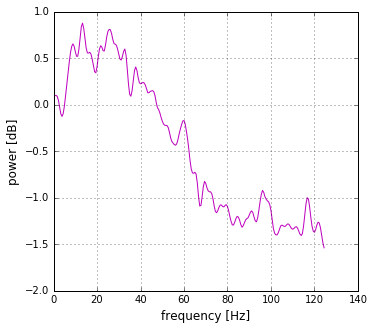

In [205]:
@interact(window=(1, 100))
def plot_smoothed_spectrum(window=10):
    f3_axis = get_faxis(s_crop, dt)
    Y3 = np.log10(abs(W3[0:len(f3_axis)//2])) # power spectrum
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(f3_axis[:len(f3_axis)//2], smooth(Y3, window_len=window),'m', lw=1)
    ax.set_xlabel('frequency [Hz]', fontsize=12)
    ax.set_ylabel('power [dB]', fontsize=12)
    ax.grid()

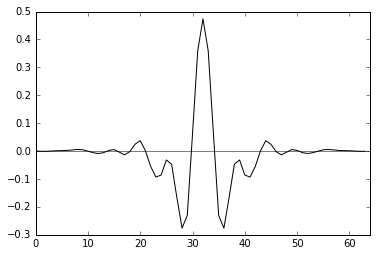

In [218]:
@interact(window=(1, 150))
def plot_spec_div_wavelet(window=10):
    w3 = ifft(smooth(W3, window_len=window))
    w3r = np.flipud(w3)
    w3 = -1*np.concatenate((w3r[-32-1:-1],w3[:32]))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(w3, 'k')
    ax.set_xlim(0,64)
    ax.axhline(0, color='k',alpha=0.5)

# 4. Wavelet estimation by least squares

Wiener Filter method (?)

In [219]:
def opConvolve(data, kernel_size):
    op = np.zeros((data.size-kernel_size+1, kernel_size))
    for i in range(data.size-kernel_size):
        op[i, :] = data[i:i+kernel_size]
    return op

In [260]:
from numpy.linalg import solve, lstsq

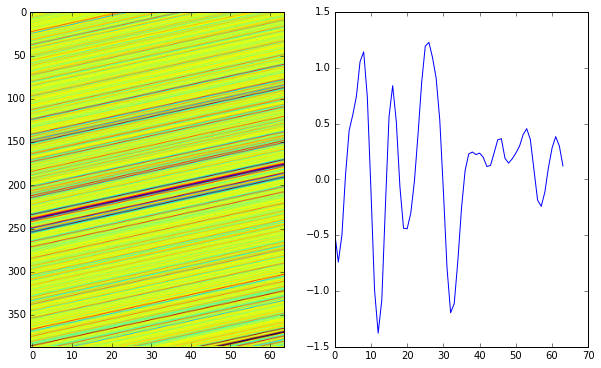

In [261]:
# plotting stuff
@interact(n1=(0, 500), dn=(300,600), b=(-100,100))
def plot_trace(n1,dn,b):
    
    trace = norm(data[n1:n1+dn, x])
    r_crop = r[n1+b:n1+dn+b]
    
    C = opConvolve(np.transpose(r_crop), 64)
    s_inv = trace[dw//2:-dw//2+1]
    w4 = lstsq(C, s_inv)[0]
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(121)
    ax.imshow(C, aspect='auto')
    ax2 = fig.add_subplot(122)
    ax2.plot(w4)

# Plot wavelets

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


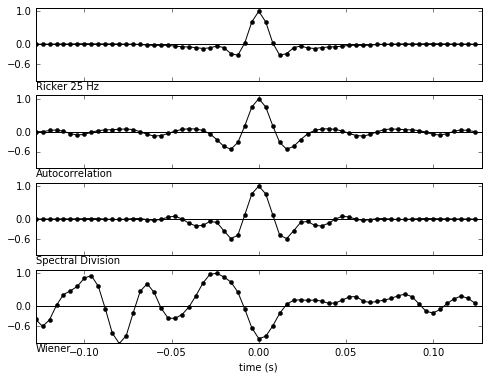

In [253]:
### Two subplots, the axes array is 1-d
wavelets = [w1, w2, w3, w4]
labels = ['Ricker 25 Hz', 'Autocorrelation', 'Spectral Division', 'Wiener']
f, axarr = plt.subplots(len(wavelets), sharex=True,figsize=(8,6))
for i, w in enumerate(wavelets):
    xlabel = False
    if i==len(wavelets)-1:
        xlabel = True
    plot_wavelet(norm(w), tw, axarr[i], xlabel=xlabel, points=True, label=labels[i])
    

# Power and phase spectra of our wavelets

In [254]:
# do that here

# Make synthetics

In [267]:
s1 =  np.convolve(w1, r, mode='same')  # visual
s2 =  np.convolve(w2, r, mode='same')  # autocorrelation
s3 =  np.convolve(w3, r, mode='same')  # spectral division
s4 =  np.convolve(w4, r, mode='same')  # Wiener Levinson
#s4 = np.dot(C, w4) # least squares

# Correlations

In [268]:
def plot_traces(ax, data, tbase, ntraces=3, gain=1, dtr = 1.0, xlim=(-1.0,0), ylim=(0,3.0), ylabel=False, norm=True, points=False):
    if points:
        point = 'ko-'
    else:
        point = 'k'
    for i in range(ntraces):
        ax.plot(dtr*i + gain*data, tbase, point)
        ax.fill_betweenx(tbase, dtr*i + gain*data,  dtr*i, data > 0.0,  color='k', alpha = 1.0)

        #ax.axvline(dtr*i, color='k', lw=0.5)
    ax.set_xlim((xlim[0],xlim[1]+ntraces))
    ax.set_ylim((ylim[0],ylim[1]))
    ax.invert_yaxis()
    if ylabel:
        ax.set_ylabel('time (s)')
    ax.set_xticks([])
    #ax.axis('off')
    return ax

# Get some tops for reference

In [269]:
tops = {'Abenaki': 2.464481997278976,
 'Base O-Marker': 1.9831661738768789,
 'Dawson Canyon': 1.0092858736127031,
 'L Baccaro': 2.7125863889183219,
 'L Missisauga': 2.361502648983643,
 'Logan Canyon': 1.1345061376197538,
 'Mid Baccaro': 2.4982437733593552,
 'U Missisauga': 1.869903991252488,
 'Wyandot': 0.92197301601869186}

# <span style="color:red">Envelope!</span>

# <span style="color:red">Modify t-d relationships! As it doesn't look quite right.</span>

corr start time:  1.0
corr end time:  2.6


/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Evan/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:4798: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[1:N + 1, 0] = x1slice


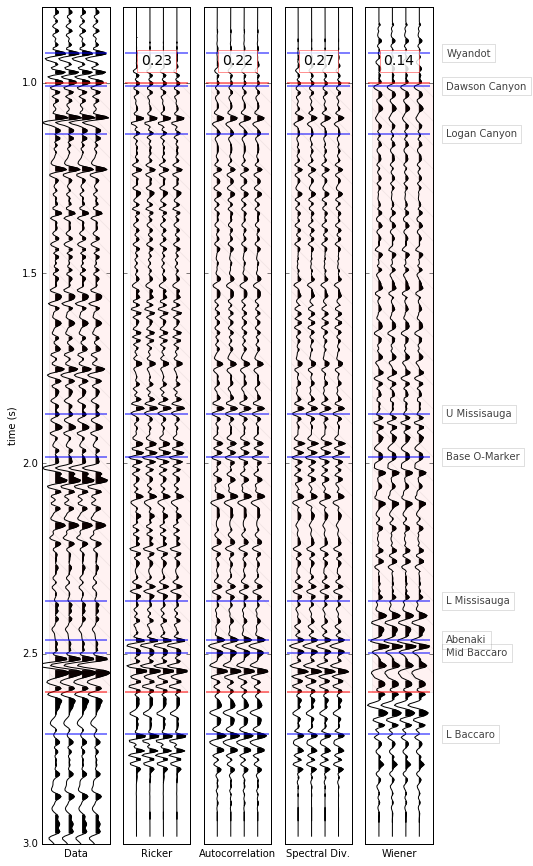

In [271]:
# Plot params

top_t = 0.8  # start time of plot
base_t = 3.0  # end time of plot
lag = 3
traces = [norm(s[lag:]), s1[:-lag], s2[:-lag], s3[:-lag], s4[:-lag]]
trace_labels = ['Data', 'Ricker', 'Autocorrelation', 'Spectral Div.', 'Wiener']
scalar = 0.75
gain = scalar*np.array([3, 1, 1, 1, 1])

# plotting stuff
@interact(c1=(0, 750), c2=(0,750))
def plot_synthetics(c1=250,c2=400):

    # Correlation params
    #c1 = n1  # sample number to start correlation
    #c2 = dn  # length of window for correlation
    print ('corr start time: ', c1*dt)
    print ('corr end time: ', dt*(c1+c2))
    ccff = []
    for signal in traces[1:]:
        ccff.append(np.corrcoef(abs(traces[0])[c1:c1+c2],abs(signal)[c1:c1+c2])[0][1])

    f, axarr = plt.subplots(1,len(traces), sharey=True,figsize=(7,15))
    for i, d in enumerate(traces):
        ylabel = False
        if i==0:
            ylabel = True
        plot_traces(axarr[i],norm(d),np.arange(0,len(d),1)*dt, ntraces=4,
                    gain = gain[i],
                    ylabel=ylabel, 
                    norm=False)
        axarr[i].set_xlabel(trace_labels[i])
        axarr[i].set_ylim((base_t,top_t))

        for name, twt in tops.items():
            axarr[i].axhline(y = float(twt), color = 'b', lw = 2, 
                             alpha = 0.5, xmin = 0.05, xmax = 0.95)
            if i == len(traces)-1:
                axarr[i].text(x = 5, y = float(twt), s = name,
                          alpha=0.75, color='k',
                          fontsize = '10',
                          horizontalalignment = 'left',
                          verticalalignment = 'center',
                          bbox=dict(facecolor='white', alpha=0.25, lw = 0.5),
                          weight = 'light')

        axarr[i].add_patch(patches.Rectangle((-0.5, c1*dt),5.5,c2*dt, hatch='\\', alpha=0.05, fc='r'))

        axarr[i].axhline(y = c1*dt, color = 'r', lw = 2, 
                        alpha = 0.5, xmin = 0.05, xmax = 0.95)
        axarr[i].axhline(y = (c1+c2)*dt, color = 'r', lw = 2, 
                        alpha = 0.5, xmin = 0.05, xmax = 0.95)
        if i != 0:
            axarr[i].text(x = 1.5, y = (c1-10)*dt, s = "{:.2f}".format(ccff[i-1]),
                          alpha=1.0, color='k',
                          fontsize = '14',
                          horizontalalignment = 'center',
                          verticalalignment = 'bottom',
                          bbox=dict(facecolor='white', ec='r', alpha=0.85, lw = 0.5),
                          weight = 'normal')


